# ECE 9039 Machine Learning Project

In [ ]:
pip install tensorflow-addons

     |████████████████████████████████| 706kB 11.1MB/s 


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers

tfds.disable_progress_bar()
autotune = tf.data.experimental.AUTOTUNE

Set Random Seeds

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
buffer_size = 1000
batch_size = 1

In [ ]:
MONET_FILENAMES = tf.io.gfile.glob('monet*.tfrec')
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob('photo*.tfrec')
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 4


In [ ]:
input_img_size = (256, 256, 3)
resized_img_size = (286, 286)

Helper functions

In [ ]:
def preprocess_train_image(image):
    image = tf.image.decode_jpeg(image, channels=3)

    # random resizing to 286*286
    image = tf.image.resize(image, [*resized_img_size], method=tf.image.ResizeMethod.BICUBIC)
    # random cropping to 256*256
    image = tf.image.random_crop(image, size=[*input_img_size])
    # random flipping
    image = tf.image.random_flip_left_right(image)

    # Normalization
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [256, 256, 3])

    return image

In [ ]:
def preprocess_test_image(image):
    image = tf.image.decode_jpeg(image, channels=3)

    # Normalization
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [256, 256, 3])

    return image

In [ ]:
def read_train_tfrecord(example):
    tfrecord_format = {
        'image': tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrecord_format)

    image = preprocess_train_image(example['image'])

    return image

In [ ]:
def read_test_tfrecord(example):
    tfrecord_format = {
        'image': tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrecord_format)

    image = preprocess_test_image(example['image'])

    return image

In [ ]:
def load_dataset(x_filenames, y_filenames, train_size=0.85):
    full_ds_x = tf.data.TFRecordDataset(x_filenames)
    full_ds_y = tf.data.TFRecordDataset(y_filenames)

    ds_size_x = sum(1 for _ in full_ds_x)
    print("full ds_x size: " + str(ds_size_x))

    ds_size_y = sum(1 for _ in full_ds_y)
    print("full ds_y size: " + str(ds_size_y))

    # align monet & photo set size
    full_ds_y = full_ds_y.take(ds_size_x)

    train_size = int(train_size * ds_size_x)

    # prepare monet train & test
    x_train_ds = full_ds_x.take(train_size)
    x_test_ds = full_ds_x.skip(train_size)

    x_train_ds = x_train_ds.map(read_train_tfrecord, num_parallel_calls=autotune).cache().shuffle(buffer_size).batch(batch_size)
    x_test_ds = x_test_ds.map(read_test_tfrecord, num_parallel_calls=autotune).cache().shuffle(buffer_size).batch(batch_size)

    # prepare photo train & test
    y_train_ds = full_ds_y.take(train_size)
    y_test_ds = full_ds_y.skip(train_size)

    # prepare tf.dataset objects
    y_train_ds = y_train_ds.map(read_train_tfrecord, num_parallel_calls=autotune).cache().shuffle(buffer_size).batch(batch_size)
    y_test_ds = y_test_ds.map(read_test_tfrecord, num_parallel_calls=autotune).cache().shuffle(buffer_size).batch(batch_size)
    
    return x_train_ds, x_test_ds, y_train_ds, y_test_ds

Data Spliting & Preparation

In [ ]:
monet_ds_train, monet_ds_test, photo_ds_train, photo_ds_test = load_dataset(MONET_FILENAMES, PHOTO_FILENAMES, train_size=0.90)

full ds_x size: 1193
full ds_y size: 1408


In [ ]:
monet_train_size = sum(1 for _ in monet_ds_train)
print("monet train ds size: " + str(monet_train_size))

monet_test_size = sum(1 for _ in monet_ds_test)
print("monet test ds size: " + str(monet_test_size))

photo_train_size = sum(1 for _ in photo_ds_train)
print("photo train ds size: " + str(photo_train_size))

photo_test_size = sum(1 for _ in photo_ds_test)
print("photo test ds size: " + str(photo_test_size))

monet train ds size: 1073
monet test ds size: 120
photo train ds size: 1073
photo test ds size: 120


Visualize Monet vs Photo

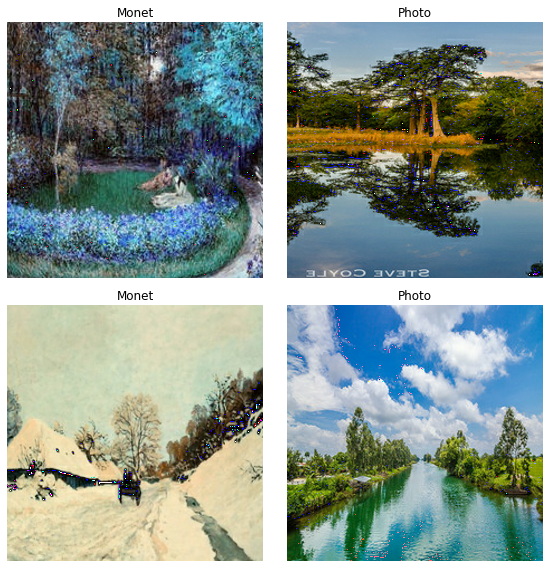

In [ ]:
_, ax = plt.subplots(2, 2, figsize=(8, 8))
sample_monet = monet_ds_train.take(2)
sample_photo = photo_ds_train.take(2)
for i, samples in enumerate(zip(sample_monet, sample_photo)):
    monet = (((samples[0][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    photo = (((samples[1][0] * 127.5) + 127.5).numpy()).astype(np.uint8)

    ax[i, 0].imshow(monet)
    ax[i, 1].imshow(photo)
    ax[i, 0].set_title('Monet')
    ax[i, 1].set_title('Photo')
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')
plt.tight_layout()
plt.show()

Visualize preprocessing effects on Monet

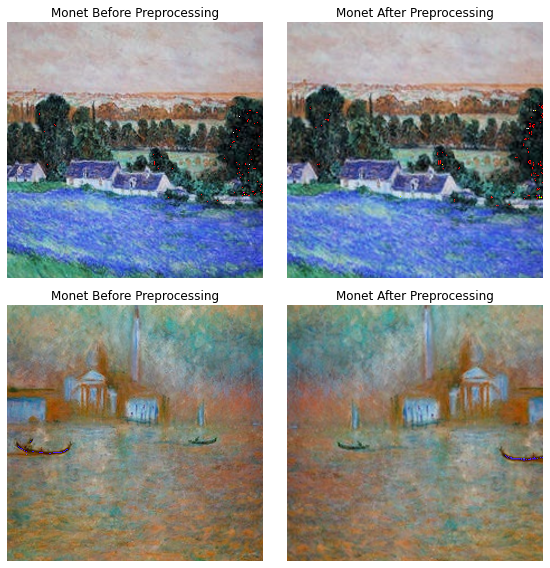

In [ ]:
_, ax = plt.subplots(2, 2, figsize=(8, 8))
for i, samples in enumerate(sample_monet):
    monet = (((samples[0] * 127.5) + 127.5).numpy()).astype(np.uint8)

    # random resizing to 286*286
    processed_monet = tf.image.resize(monet, [*resized_img_size], method=tf.image.ResizeMethod.BICUBIC)
    # random cropping to 256*256
    processed_monet = tf.image.random_crop(processed_monet, size=[*input_img_size])
    # random flipping
    processed_monet = tf.image.random_flip_left_right(processed_monet)

    processed_monet = (processed_monet.numpy()).astype(np.uint8)

    ax[i, 0].imshow(monet)
    ax[i, 1].imshow(processed_monet)
    ax[i, 0].set_title('Monet Before Preprocessing')
    ax[i, 1].set_title('Monet After Preprocessing')
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')

plt.tight_layout()
plt.show()

Color channels distribution plots

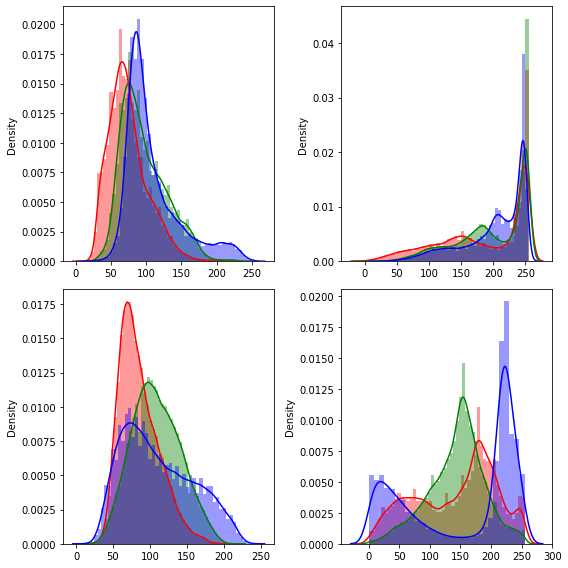

In [ ]:
import warnings

def action_with_warnings():
    warnings.warn("distplot")

with warnings.catch_warnings(record=True):
    action_with_warnings()

    _, ax = plt.subplots(2, 2, figsize=(8, 8))
    for i, samples in enumerate(zip(sample_monet, sample_photo)):
      monet = (((samples[0][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
      photo = (((samples[1][0] * 127.5) + 127.5).numpy()).astype(np.uint8)
    
      sns.distplot(monet[:,:,0],  ax=ax[i,0], color='r')
      sns.distplot(monet[:,:,1],  ax=ax[i,0], color='g')
      sns.distplot(monet[:,:,2],  ax=ax[i,0], color='b')

      sns.distplot(photo[:,:,0],  ax=ax[i,1], color='r')
      sns.distplot(photo[:,:,1],  ax=ax[i,1], color='g')
      sns.distplot(photo[:,:,2],  ax=ax[i,1], color='b')

    plt.tight_layout()
    plt.show()


Modeling

In [ ]:
# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

In [ ]:
class ReflectionPadding2D(layers.Layer):
    """Implements Reflection Padding as a layer.

    Args:
        padding(tuple): Amount of padding for the
        spatial dimensions.

    Returns:
        A padded tensor with the same type as the input tensor.
    """

    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")


def residual_block(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x


def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


def upsample(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(2, 2),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x


In [ ]:
def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(
        x
    )
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.Activation("relu"))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.Activation("relu"))

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.Activation("relu"))

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(img_input, x, name=name)
    return model

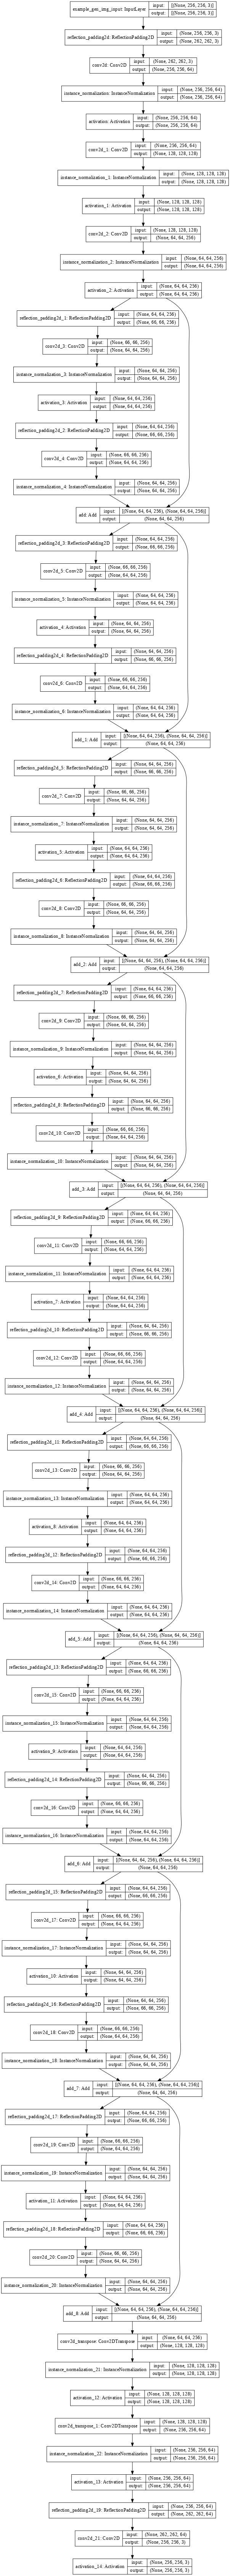

In [ ]:
generator = get_resnet_generator(name='example_gen')
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [ ]:
def get_discriminator(
    filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = layers.Conv2D(
        filters,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    x = layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer
    )(x)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model


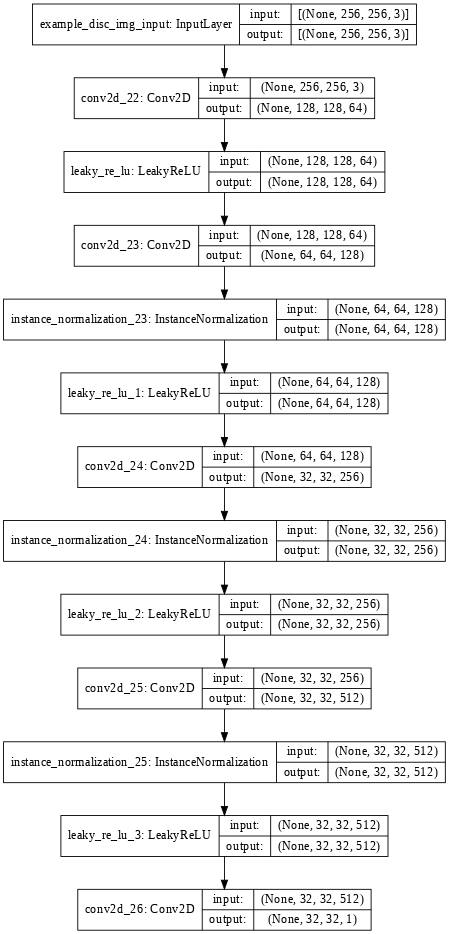

In [ ]:
discriminator = get_discriminator(name='example_disc')
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [ ]:
class CycleGan(keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10.0,
        lambda_identity=0.5,
    ):
        super(CycleGan, self).__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super(CycleGan, self).compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        # x is Monet and y is Photo
        real_x, real_y = batch_data

        # For CycleGAN, we need to calculate different
        # kinds of losses for the generators and discriminators.
        # We will perform the following steps here:
        #
        # 1. Pass real images through the generators and get the generated images
        # 2. Pass the generated images back to the generators to check if we
        #    we can predict the original image from the generated image.
        # 3. Do an identity mapping of the real images using the generators.
        # 4. Pass the generated images in 1) to the corresponding discriminators.
        # 5. Calculate the generators total loss (adverserial + cycle + identity)
        # 6. Calculate the discriminators loss
        # 7. Update the weights of the generators
        # 8. Update the weights of the discriminators
        # 9. Return the losses in a dictionary

        with tf.GradientTape(persistent=True) as tape:
            # Monet to fake photo
            fake_y = self.gen_G(real_x, training=True)
            # photo to fake Monet -> y2x
            fake_x = self.gen_F(real_y, training=True)

            # Cycle (Monet to fake photo to fake Monet): x -> y -> x
            cycled_x = self.gen_F(fake_y, training=True)
            # Cycle (Photo to fake Monet to fake Photo) y -> x -> y
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True)
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True)
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adverserial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y)
            gen_F_loss = self.generator_loss_fn(disc_fake_x)

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables)
        )
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables)
        )

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables)
        )
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables)
        )

        return {
            "monet_gen_loss": total_loss_G,
            "photo_gen_loss": total_loss_F,
            "monet_disc_loss": disc_X_loss,
            "photo_disc_loss": disc_Y_loss,
        }

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    """A callback to generate and save images after each epoch"""

    def __init__(self, num_img=4):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        _, ax = plt.subplots(4, 2, figsize=(8, 8))
        for i, img in enumerate(photo_ds_test.take(self.num_img)):
            prediction = self.model.gen_F(img)[0].numpy()
            prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
            img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

            ax[i, 0].imshow(img)
            ax[i, 1].imshow(prediction)
            ax[i, 0].set_title("Input image")
            ax[i, 1].set_title("Translated image")
            ax[i, 0].axis("off")
            ax[i, 1].axis("off")

        plt.show()
        plt.close()

**Naming Convention:**

monet-generator -- > take real monet as input, generate fake photo

photo-gen -- > take real photo as input, generate fake monet

In [ ]:
# Get the generators
monet_gen = get_resnet_generator(name="monet_gen")
photo_gen = get_resnet_generator(name="photo_gen")

# Get the discriminators
monet_discriminator = get_discriminator(name="monet_disc")
photo_discriminator = get_discriminator(name="photo_disc")

In [ ]:
# Loss function for evaluating adversarial loss
#adv_loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
adv_loss_fn = keras.losses.MeanSquaredError()

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss


# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5


# # Create cycle gan model
# cycle_gan_model = CycleGan(
#     generator_G=monet_gen, generator_F=photo_gen, discriminator_X=monet_discriminator, discriminator_Y=photo_discriminator
# )

# # Compile the model
# cycle_gan_model.compile(
#     gen_G_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
#     gen_F_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
#     disc_X_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
#     disc_Y_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
#     gen_loss_fn=generator_loss_fn,
#     disc_loss_fn=discriminator_loss_fn,
# )

# Callbacks
plotter = GANMonitor()
early_stopping = keras.callbacks.EarlyStopping(patience=10, monitor='photo_gen_loss')


# history = cycle_gan_model.fit(
#     tf.data.Dataset.zip((monet_ds_train, photo_ds_train)),
#     epochs=30,
#     callbacks=[early_stopping]
# )

**Hyper-parameter Tuning**

In [ ]:
!pip install -q -U keras-tuner
import kerastuner as kt

     |████████████████████████████████| 71kB 6.0MB/s 


In [ ]:
def build_model(hp):

    hp_downsample = hp.Choice('downsampling_block', values=[1, 2, 3])

    # Get the generators
    monet_gen = get_resnet_generator(name="monet_gen", num_downsampling_blocks=hp_downsample, num_upsample_blocks=hp_downsample)
    photo_gen = get_resnet_generator(name="photo_gen", num_downsampling_blocks=hp_downsample, num_upsample_blocks=hp_downsample)

    # Get the discriminators
    monet_discriminator = get_discriminator(name="monet_disc")
    photo_discriminator = get_discriminator(name="photo_disc")

    # Create cycle gan model
    cycle_gan_model = CycleGan(
      generator_G=monet_gen, generator_F=photo_gen, discriminator_X=monet_discriminator, discriminator_Y=photo_discriminator
    )

    # Compile the model
    cycle_gan_model.compile(
      gen_G_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
      gen_F_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
      disc_X_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
      disc_Y_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
      gen_loss_fn=generator_loss_fn,
      disc_loss_fn=discriminator_loss_fn,
    )

    return cycle_gan_model


tuner = kt.RandomSearch(build_model, objective=kt.Objective('photo_gen_loss', direction='min'), max_trials=4, seed=42)

tuner.search(tf.data.Dataset.zip((monet_ds_train, photo_ds_train)),
    epochs=30,
    callbacks=[early_stopping])

Trial 3 Complete [03h 04m 20s]
photo_gen_loss: 1.8679534196853638

Best photo_gen_loss So Far: 1.8679534196853638
Total elapsed time: 07h 45m 48s
INFO:tensorflow:Oracle triggered exit


Display tuner results

In [ ]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='photo_gen_loss', direction='min')
Trial summary
Hyperparameters:
downsampling_block: 2
Score: 1.8679534196853638
Trial summary
Hyperparameters:
downsampling_block: 1
Score: 1.966766595840454
Trial summary
Hyperparameters:
downsampling_block: 3
Score: 2.178243637084961


Retain the optimal hyper-parameters and re-train the model

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

cycle_gan_model = tuner.hypermodel.build(best_hps)

history = cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds_train, photo_ds_train)),
    epochs=30,
    callbacks=[early_stopping]
)

Epoch 1/30
1073/1073 [==============================] - 441s 352ms/step - monet_gen_loss: 4.9248 - photo_gen_loss: 4.5838 - monet_disc_loss: 0.1567 - photo_disc_loss: 0.1603
Epoch 2/30
1073/1073 [==============================] - 378s 352ms/step - monet_gen_loss: 4.0183 - photo_gen_loss: 3.8772 - monet_disc_loss: 0.1919 - photo_disc_loss: 0.1729
Epoch 3/30
1073/1073 [==============================] - 378s 352ms/step - monet_gen_loss: 3.9729 - photo_gen_loss: 3.5940 - monet_disc_loss: 0.1927 - photo_disc_loss: 0.1356
Epoch 4/30
1073/1073 [==============================] - 379s 353ms/step - monet_gen_loss: 3.8366 - photo_gen_loss: 3.5626 - monet_disc_loss: 0.1785 - photo_disc_loss: 0.1526
Epoch 5/30
1073/1073 [==============================] - 379s 353ms/step - monet_gen_loss: 3.6432 - photo_gen_loss: 3.4731 - monet_disc_loss: 0.1827 - photo_disc_loss: 0.1854
Epoch 6/30
1073/1073 [==============================] - 379s 353ms/step - monet_gen_loss: 3.5289 - photo_gen_loss: 3.3081 - monet_

Plot loss vs Epochs

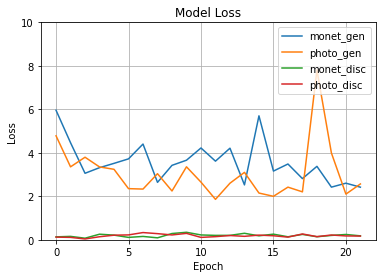

In [ ]:
plt.plot(history.history['monet_gen_loss'])
plt.plot(history.history['photo_gen_loss'])
plt.plot(history.history['monet_disc_loss'])
plt.plot(history.history['photo_disc_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim(0, 10)
plt.legend(['monet_gen', 'photo_gen', 'monet_disc', 'photo_disc'], loc='upper right')
plt.grid(True)
plt.show()

Visualize photo -> photo in Monet-style

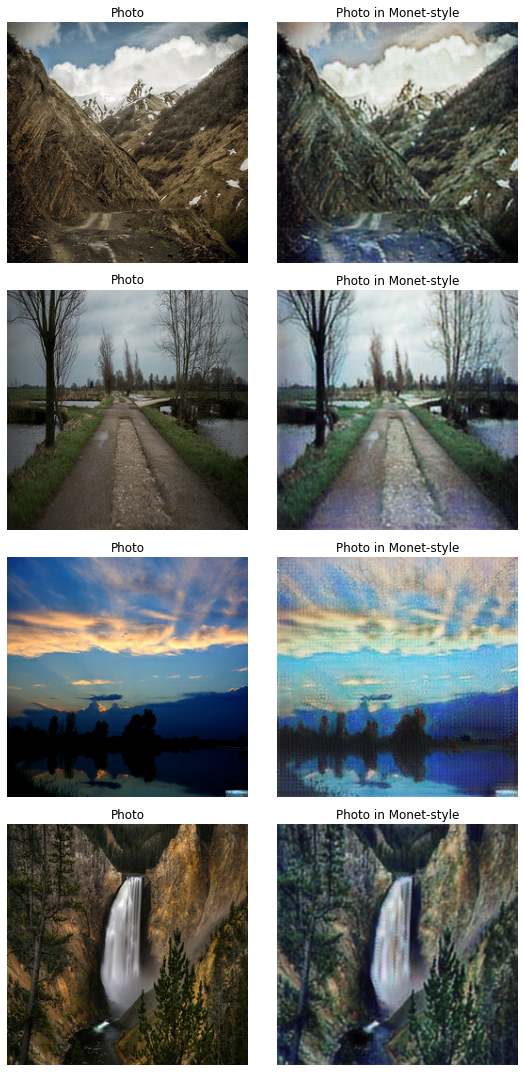

In [ ]:
_, ax = plt.subplots(4, 2, figsize=(8, 15))
for i, img in enumerate(photo_ds_test.take(4)):
    prediction = cycle_gan_model.gen_F(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Photo")
    ax[i, 1].set_title("Photo in Monet-style")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")

    prediction = keras.preprocessing.image.array_to_img(prediction)
    prediction.save("predicted_img_{i}.png".format(i=i))
plt.tight_layout()
plt.show()

Visualize Monet -> Monet in photo-style

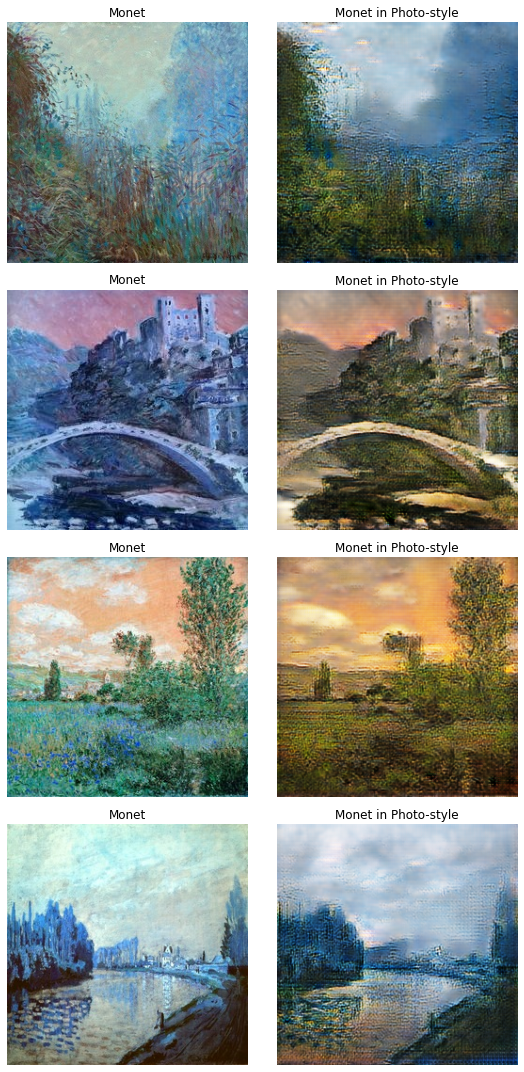

In [ ]:
_, ax = plt.subplots(4, 2, figsize=(8, 15))
for i, img in enumerate(monet_ds_test.take(4)):
    prediction = cycle_gan_model.gen_G(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Monet")
    ax[i, 1].set_title("Monet in Photo-style")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")

plt.tight_layout()
plt.show()

Save translated images and original images

In [ ]:
!mkdir ./original
!mkdir ./translated

In [ ]:
prediction_list = []
for i, img in enumerate(photo_ds_test):
    prediction = cycle_gan_model.gen_F(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)

    prediction_list.append(prediction)

    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    
    img = keras.preprocessing.image.array_to_img(img)
    prediction = keras.preprocessing.image.array_to_img(prediction)

    img.save("./original/" + "original_img_{i}.png".format(i=i))
    prediction.save("./translated/" + "translated_img_{i}.png".format(i=i))

In [ ]:
!zip -r original.zip original/
!zip -r translated.zip translated/

  adding: original/ (stored 0%)
  adding: original/original_img_79.png (deflated 0%)
  adding: original/original_img_0.png (deflated 0%)
  adding: original/original_img_107.png (deflated 0%)
  adding: original/original_img_8.png (deflated 0%)
  adding: original/original_img_55.png (deflated 0%)
  adding: original/original_img_57.png (deflated 0%)
  adding: original/original_img_93.png (deflated 0%)
  adding: original/original_img_1.png (deflated 0%)
  adding: original/original_img_118.png (deflated 0%)
  adding: original/original_img_108.png (deflated 0%)
  adding: original/original_img_117.png (deflated 0%)
  adding: original/original_img_56.png (deflated 0%)
  adding: original/original_img_115.png (deflated 0%)
  adding: original/original_img_5.png (deflated 0%)
  adding: original/original_img_45.png (deflated 1%)
  adding: original/original_img_63.png (deflated 0%)
  adding: original/original_img_38.png (deflated 0%)
  adding: original/original_img_41.png (deflated 0%)
  adding: ori

Inception Score

In [ ]:
from math import floor
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
 
# assumes images have the shape 299x299x3, pixels in [0,255]
def calculate_inception_score(images, n_split=10, eps=1E-16):
	# load inception v3 model
	model = InceptionV3()
	# convert from uint8 to float32
	processed = images.astype('float32')
	# pre-process raw images for inception v3 model
	processed = preprocess_input(processed)
	# predict class probabilities for images
	yhat = model.predict(processed)
	# enumerate splits of images/predictions
	scores = list()
	n_part = floor(images.shape[0] / n_split)
	for i in range(n_split):
		# retrieve p(y|x)
		ix_start, ix_end = i * n_part, i * n_part + n_part
		p_yx = yhat[ix_start:ix_end]
		# calculate p(y)
		p_y = np.expand_dims(np.mean(p_yx, axis=0), 0)
		# calculate KL divergence using log probabilities
		kl_d = p_yx * (np.log(p_yx + eps) - np.log(p_y + eps))
		# sum over classes
		sum_kl_d = kl_d.sum(axis=1)
		# average over images
		avg_kl_d = np.mean(sum_kl_d)
		# undo the log
		is_score = np.exp(avg_kl_d)
		# store
		scores.append(is_score)
	# average across images
	is_avg, is_std = np.mean(scores), np.std(scores)
	return is_avg, is_std

In [ ]:
resized_prediction_list = []
for prediction in (prediction_list):

    prediction_resized = tf.image.resize(prediction, [299, 299], method=tf.image.ResizeMethod.BILINEAR)
    resized_prediction_list.append(prediction_resized)

resized_prediction_list = np.array(resized_prediction_list)
print(resized_prediction_list.shape)

# calculate inception score
is_avg, is_std = calculate_inception_score(resized_prediction_list)

inception_score = pd.DataFrame(columns=['is_avg', 'is_std'])
inception_score = inception_score.append({'is_avg':is_avg, 'is_std':is_std}, ignore_index=True)
inception_score

(120, 299, 299, 3)
96116736/96112376 [==============================] - 4s 0us/step


is_avg    is_std
0  3.821115  0.228903

Frechet Inception Distance

In [ ]:
from scipy.linalg import sqrtm
 
# calculate frechet inception distance
def calculate_fid(model, images1, images2):
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(images2)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = np.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if np.iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid

In [ ]:
monet_list = []
for i, img in enumerate(monet_ds_test):
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    monet_list.append(img)

monet_list = np.array(monet_list)
print(monet_list.shape)

(120, 256, 256, 3)


In [ ]:
# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

# convert integer to floating point values
monet_list = monet_list.astype('float32')

# resize images
resized_monet_list = []
for img in (monet_list):

    img_resized = tf.image.resize(img, [299, 299], method=tf.image.ResizeMethod.BILINEAR)
    resized_monet_list.append(img_resized)

resized_monet_list = np.array(resized_monet_list)
print(resized_monet_list.shape)

# pre-process images
images1 = preprocess_input(resized_monet_list)
images2 = preprocess_input(resized_prediction_list)

# fid between images1 and images1
fid_same = calculate_fid(model, images1, images1)
# fid between images1 and images2
fid_diff = calculate_fid(model, images1, images2)

fid_score = pd.DataFrame(columns=['FID_same', 'FID_diff'])
fid_score = fid_score.append({'FID_same': fid_same, 'FID_diff':fid_diff}, ignore_index=True)
fid_score

87916544/87910968 [==============================] - 1s 0us/step
(120, 299, 299, 3)


FID_same   FID_diff
0 -0.000054  175.83067